<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/OSRM-Routing-/blob/main/osmnx_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express
!pip install pykrige geopandas

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,514 kB/s)
Selecting previously unselected package pytho

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.9 MB 418 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 869 kB 12.7 MB/s 


In [ ]:
pip install osmnx==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 5.2 MB/s 
  Attempting uninstall: osmnx
    Found existing installation: osmnx 1.2.2
    Uninstalling osmnx-1.2.2:
      Successfully uninstalled osmnx-1.2.2


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox


from pykrige.ok import OrdinaryKriging
from scipy.interpolate import NearestNDInterpolator
import pandas as pd
import geopandas as gpd
import plotly.express as px

ox.config(use_cache=True, log_console=True)



# from skgstat import Variogram
# import osmnx as ox

from pykrige.ok import OrdinaryKriging
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import RBFInterpolator  
import pandas as pd
import geopandas as gpd
import plotly.express as px

In [ ]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

/usr/local/lib/python3.8/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.8/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.8/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


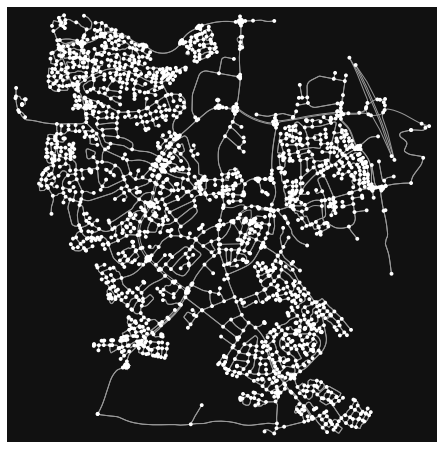

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [ ]:
G = create_graph("Banbury, UK", 2500, "drive")
ox.plot_graph(G)

In [ ]:
# impute missing edge speeds and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
start = (52.071321, -1.363559)
end = (52.064668, -1.305744)
start_node = ox.get_nearest_node(G, start) 
end_node = ox.get_nearest_node(G, end)
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
    


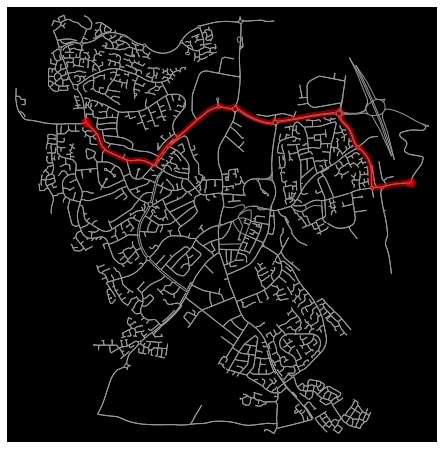

In [ ]:
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k' );

In [ ]:
nx.shortest_path_length

<function networkx.algorithms.shortest_paths.generic.shortest_path_length(G, source=None, target=None, weight=None, method='dijkstra')>

In [ ]:
travel_time = nx.shortest_path_length(G, start_node, end_node, weight='travel_time')
print(round(travel_time))

314


In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,1628201641,15830375,-1.363418,52.071204,-1.361617,52.069977,184,14
1,15830375,28264485,-1.361617,52.069977,-1.360150,52.068293,215,16
2,28264485,7404176252,-1.360150,52.068293,-1.357043,52.067339,238,18
3,7404176252,28264484,-1.357043,52.067339,-1.356344,52.067163,52,4
4,28264484,8701222220,-1.356344,52.067163,-1.351910,52.066679,314,23


In [ ]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,1628201641,15830375,-1.363418,52.071204,-1.361617,52.069977,184,14
1,1,15830375,28264485,-1.361617,52.069977,-1.360150,52.068293,215,16
2,2,28264485,7404176252,-1.360150,52.068293,-1.357043,52.067339,238,18
3,3,7404176252,28264484,-1.357043,52.067339,-1.356344,52.067163,52,4
4,4,28264484,8701222220,-1.356344,52.067163,-1.351910,52.066679,314,23


In [ ]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

In [ ]:
line_gdf = create_line_gdf(df)

/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot: >

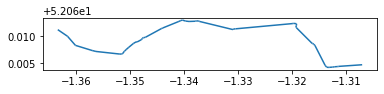

In [ ]:
line_gdf.plot()

In [ ]:
line_gdf.head()

,node_start,node_end,length,travel_time,line
0,1628201641,15830375,184,14,"LINESTRING (-1.36162 52.06998, -1.36342 52.07120)"
1,15830375,28264485,215,16,"LINESTRING (-1.36015 52.06829, -1.36162 52.06998)"
2,28264485,7404176252,238,18,"LINESTRING (-1.35704 52.06734, -1.36015 52.06829)"
3,7404176252,28264484,52,4,"LINESTRING (-1.35634 52.06716, -1.35704 52.06734)"
4,28264484,8701222220,314,23,"LINESTRING (-1.35191 52.06668, -1.35634 52.06716)"


In [ ]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [ ]:
start

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
0,0,1628201641,15830375,-1.363418,52.071204,-1.361617,52.069977,184,14,POINT (-1.36342 52.07120),POINT (-1.3616165 52.0699772)


In [ ]:
end

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
59,59,31959298,20626416,-1.311366,52.064393,-1.306988,52.064698,302,14,POINT (-1.31137 52.06439),POINT (-1.3069884 52.064698)


In [ ]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])



In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=13, width=1800, height=900, animation_frame="index",mapbox_style="dark")
fig.data[0].marker = dict(size = 30, color="yellow")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig